In [1]:
from lasagne import layers
from lasagnekit.misc.plot_weights import dispims_color
from skimage.io import imsave
%matplotlib inline
import sys, os
sys.path.append(os.getcwd()+"/..")
from tools.system.imgtovideo import imgs_to_video
from data import load_data
import matplotlib.pyplot as plt
import numpy as np
import theano
import theano.tensor as T
from lasagne import layers as L
from lasagnekit.misc.plot_weights import dispims_color, tile_raster_images
import pandas as pd

from tqdm import tqdm
import base64
import json

from skimage.io import imread, imsave
from skimage.transform import resize

from IPython.display import HTML, Image


from tools.brushstroke.common import (
    resize_set, load_model, get_bias, 
    get_scale, build_brush_func,
    build_encode_func,
    build_image_to_code_func,
    build_code_to_image,
    to_grid_of_images,
    seq_to_video,
    embed_video,
    disp_grid,
    prop_uniques,
    hash_array,
    normalize,
    sigmoid,
    build_pointer_images)
from helpers import GenericBrushLayer

/home/mcherti/work/code/external/scikit-learn/sklearn/cross_validation.py:43: DeprecationWarning: This module has been deprecated in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/mcherti/miniconda/envs/databoard-env/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


Couldn't import dot_parser, loading of dot files will not be possible.


In [90]:
n_steps = 1
nb_features = 13
inp = layers.InputLayer((None, n_steps, nb_features))
patches = np.ones((1, 3, 16, 16))
patches = patches.astype(np.float32)
brush = GenericBrushLayer(
    inp,
    16, 16,
    n_steps=n_steps,
    patches=patches,
    col='rgb',
    return_seq=False,
    reduce_func=lambda x,y:x+y,
    to_proba_func=T.nnet.softmax,
    normalize_func=lambda x:x,
    x_sigma=1,
    y_sigma=1,
    x_stride=1,
    y_stride=1,
    patch_index=0,
    color='predicted',
    color_min=0,
    color_max=1,
    x_min=0,
    x_max='width',
    y_min=0,
    y_max='height',
    w_left_pad='half_patch',
    w_right_pad='half_patch',
    h_left_pad='half_patch',
    h_right_pad='half_patch',
    eps=0)

In [91]:
X = T.tensor3()
fn = theano.function([X], layers.get_output(brush, X))
print(brush.assign_)

{'color': (2, 5), 'gy': 1, 'gx': 0}


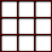

In [93]:
coord = np.zeros((9, 2, 7))
coord[:, :, 0]=0.5
coord[:, :, 1]=0.5

coord[:, :, 2] = 1
coord[:, :, 3] = 1

coord[:, :, 4] = 1
coord[:, :, 5] = 0
coord[:, :, 6] = 0

coord = coord.astype(np.float32)
y = fn(coord)
img = disp_grid(y, border=1, bordercolor=(0.3,0,0))
imsave('out.png', img)
Image('out.png', width=400, height=400)